https://openai.com/research/triton

https://www.jiqizhixin.com/articles/2021-07-29


https://www.semianalysis.com/p/nvidiaopenaitritonpytorch

https://hub.baai.ac.cn/view/23447

https://triton-lang.org/master/getting-started/tutorials/index.html

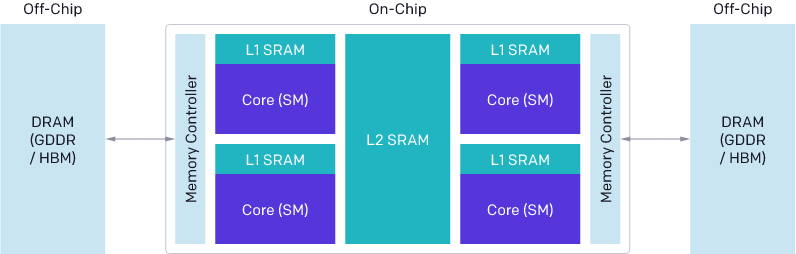

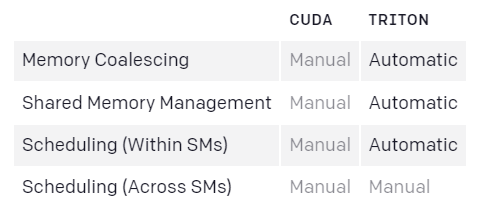

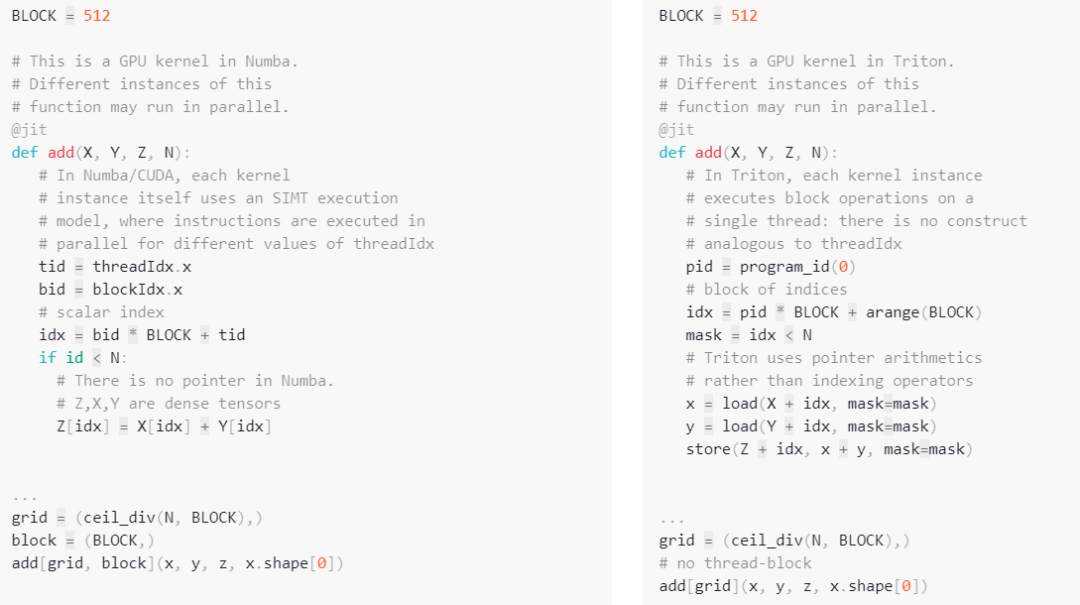

In [ ]:
!pip install triton

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 KB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-16.0.0-py3-none-any.whl size=93601 sha256=6b85ae18f5cea49f443f766f0fdd426d8971e4ba5d32bd56d5d8b9348b72e0c6
  Stored in directory: /root/.cache/pip/wheels/c7/ee/80/1520ca86c3557f70e5504b802072f7fc3b0e2147f376b133ed
Successfully built lit


In [ ]:
import torch

import triton
import triton.language as tl

@triton.jit
def add_kernel(
    x_ptr,  # *Pointer* to first input vector
    y_ptr,  # *Pointer* to second input vector
    output_ptr,  # *Pointer* to output vector
    n_elements,  # Size of the vector
    BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process
                 # NOTE: `constexpr` so it can be used as a shape value
):
    # There are multiple 'program's processing different data. We identify which program
    # we are here
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0
    # This program will process inputs that are offset from the initial data.
    # for instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Create a mask to guard memory operations against out-of-bounds accesses
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM
    tl.store(output_ptr + offsets, output, mask=mask)

In [ ]:
def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int]
    # In this case, we use a 1D grid where the size is the number of blocks
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
    # NOTE:
    #  - each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be index with a launch grid to obtain a callable GPU kernel
    #  - don't forget to pass meta-parameters as keywords arguments
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

In [ ]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(
    f'The maximum difference between torch and triton is '
    f'{torch.max(torch.abs(output_torch - output_triton))}'
)

tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
The maximum difference between torch and triton is 0.0
